You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# Distributions

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=8e6e41146b22ad051b85f9f2bdda7373ef52958c965f3d70a9572056c3d9553f
  Stored in directory: /root/.cache/pip/wheels/96/04/f1/a934ef1f5f3db621dc39566b2c7de45b8c6916044be6a9c9ac
Successfully built empiricaldist


In [3]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [4]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we used Bayes's Theorem to solve a cookie problem; then we solved it again using a Bayes table.
In this chapter, at the risk of testing your patience, we will solve it one more time using a `Pmf` object, which represents a "probability mass function".
I'll explain what that means, and why it is useful for Bayesian statistics.

We'll use `Pmf` objects to solve some more challenging problems and take one more step toward Bayesian statistics.
But we'll start with distributions.

## Distributions

In statistics a **distribution** is a set of possible outcomes and their corresponding probabilities.
For example, if you toss a coin, there are two possible outcomes with
approximately equal probability.
If you roll a six-sided die, the set of possible outcomes is the numbers 1 to 6, and the probability associated with each outcome is 1/6.

To represent distributions, we'll use a library called `empiricaldist`.
An "empirical" distribution is based on data, as opposed to a
theoretical distribution.
We'll use this library throughout the book.  I'll introduce the basic features in this chapter and we'll see additional features later.

## Probability Mass Functions

If the outcomes in a distribution are discrete, we can describe the distribution with a **probability mass function**, or PMF, which is a function that maps from each possible outcome to its probability.

`empiricaldist` provides a class called `Pmf` that represents a
probability mass function.
To use `Pmf` you can import it like this:

In [5]:
from empiricaldist import Pmf

If that doesn't work, you might have to install `empiricaldist`; try running

```
!pip install empiricaldist
```

in a code cell or

```
pip install empiricaldist
```

in a terminal window.

The following example makes a `Pmf` that represents the outcome of a
coin toss.

In [6]:
coin = Pmf()
coin['heads'] = 1/2
coin['tails'] = 1/2
coin

,0
heads,0.5
tails,0.5


`Pmf` creates an empty `Pmf` with no outcomes.
Then we can add new outcomes using the bracket operator.
In this example, the two outcomes are represented with strings, and they have the same probability, 0.5.

You can also make a `Pmf` from a sequence of possible outcomes.

The following example uses `Pmf.from_seq` to make a `Pmf` that represents a six-sided die.

In [7]:
die = Pmf.from_seq([1,2,3,4,5,6])
die

,
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In this example, all outcomes in the sequence appear once, so they all have the same probability, $1/6$.

More generally, outcomes can appear more than once, as in the following example:

In [8]:
letters = Pmf.from_seq(list('Mississippi'))
letters

,
M,0.090909
i,0.363636
p,0.181818
s,0.363636


The letter `M` appears once out of 11 characters, so its probability is $1/11$.
The letter `i` appears 4 times, so its probability is $4/11$.

Since the letters in a string are not outcomes of a random process, I'll use the more general term "quantities" for the letters in the `Pmf`.

The `Pmf` class inherits from a Pandas `Series`, so anything you can do with a `Series`, you can also do with a `Pmf`.

For example, you can use the bracket operator to look up a quantity and get the corresponding probability.

In [9]:
letters['s']

np.float64(0.36363636363636365)

In the word "Mississippi", about 36% of the letters are "s".

However, if you ask for the probability of a quantity that's not in the distribution, you get a `KeyError`.



In [10]:
try:
    letters['t']
except KeyError as e:
    print(type(e))

<class 'KeyError'>


You can also call a `Pmf` as if it were a function, with a letter in parentheses.

In [11]:
letters('s')

np.float64(0.36363636363636365)

If the quantity is in the distribution the results are the same.
But if it is not in the distribution, the result is `0`, not an error.

In [12]:
letters('t')

0

With parentheses, you can also provide a sequence of quantities and get a sequence of probabilities.

In [13]:
die([1,4,7])

array([0.16666667, 0.16666667, 0.        ])

The quantities in a `Pmf` can be strings, numbers, or any other type that can be stored in the index of a Pandas `Series`.
If you are familiar with Pandas, that will help you work with `Pmf` objects.
But I will explain what you need to know as we go along.

## The Cookie Problem Revisited

In this section I'll use a `Pmf` to solve the cookie problem from <<_TheCookieProblem>>.
Here's the statement of the problem again:

> Suppose there are two bowls of cookies.
>
> * Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies.
>
> * Bowl 2 contains 20 vanilla cookies and 20 chocolate cookies.
>
> Now suppose you choose one of the bowls at random and, without looking, choose a cookie at random. If the cookie is vanilla, what is the probability that it came from Bowl 1?

Here's a `Pmf` that represents the two hypotheses and their prior probabilities:

In [14]:
prior = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
prior

,
Bowl 1,0.5
Bowl 2,0.5


This distribution, which contains the prior probability for each hypothesis, is called (wait for it) the **prior distribution**.

To update the distribution based on new data (the vanilla cookie),
we multiply the priors by the likelihoods. The likelihood
of drawing a vanilla cookie from Bowl 1 is `3/4`. The likelihood
for Bowl 2 is `1/2`.

In [15]:
likelihood_vanilla = [0.75, 0.5]
posterior = prior * likelihood_vanilla
posterior

,
Bowl 1,0.375
Bowl 2,0.250


The result is the unnormalized posteriors; that is, they don't add up to 1.
To make them add up to 1, we can use `normalize`, which is a method provided by `Pmf`.

In [16]:
posterior.normalize()

np.float64(0.625)

The return value from `normalize` is the total probability of the data, which is $5/8$.

`posterior`, which contains the posterior probability for each hypothesis, is called (wait now) the **posterior distribution**.

In [17]:
posterior

,
Bowl 1,0.6
Bowl 2,0.4


From the posterior distribution we can select the posterior probability for Bowl 1:

In [18]:
posterior('Bowl 1')

np.float64(0.6)

And the answer is 0.6.

One benefit of using `Pmf` objects is that it is easy to do successive updates with more data.
For example, suppose you put the first cookie back (so the contents of the bowls don't change) and draw again from the same bowl.
If the second cookie is also vanilla, we can do a second update like this:

In [19]:
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,
Bowl 1,0.692308
Bowl 2,0.307692


Now the posterior probability for Bowl 1 is almost 70%.
But suppose we do the same thing again and get a chocolate cookie.

Here are the likelihoods for the new data:

In [20]:
likelihood_chocolate = [0.25, 0.5]

And here's the update.

In [21]:
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,
Bowl 1,0.529412
Bowl 2,0.470588


Now the posterior probability for Bowl 1 is about 53%.
After two vanilla cookies and one chocolate, the posterior probabilities are close to 50/50.

## 101 Bowls

Next let's solve a cookie problem with 101 bowls:

* Bowl 0 contains 0% vanilla cookies,

* Bowl 1 contains 1% vanilla cookies,

* Bowl 2 contains 2% vanilla cookies,

and so on, up to

* Bowl 99 contains 99% vanilla cookies, and

* Bowl 100 contains all vanilla cookies.

As in the previous version, there are only two kinds of cookies, vanilla and chocolate.  So Bowl 0 is all chocolate cookies, Bowl 1 is 99% chocolate, and so on.

Suppose we choose a bowl at random, choose a cookie at random, and it turns out to be vanilla.  What is the probability that the cookie came from Bowl $x$, for each value of $x$?

To solve this problem, I'll use `np.arange` to make an array that represents 101 hypotheses, numbered from 0 to 100.

In [22]:
import numpy as np

hypos = np.arange(101)

We can use this array to make the prior distribution:

In [23]:
prior = Pmf(1, hypos)
prior.normalize()

np.int64(101)

As this example shows, we can initialize a `Pmf` with two parameters.
The first parameter is the prior probability; the second parameter is a sequence of quantities.

In this example, the probabilities are all the same, so we only have to provide one of them; it gets "broadcast" across the hypotheses.
Since all hypotheses have the same prior probability, this distribution is **uniform**.

Here are the first few hypotheses and their probabilities.

In [24]:
prior.head()

,0
0,0.009901
1,0.009901
2,0.009901


The likelihood of the data is the fraction of vanilla cookies in each bowl, which we can calculate using `hypos`:

In [25]:
likelihood_vanilla = hypos/100
likelihood_vanilla[:5]

array([0.  , 0.01, 0.02, 0.03, 0.04])

Now we can compute the posterior distribution in the usual way:


In [26]:
posterior1 = prior * likelihood_vanilla
posterior1.normalize()
posterior1.head()

,0
0,0.000000
1,0.000198
2,0.000396


The following figure shows the prior distribution and the posterior distribution after one vanilla cookie.

In [27]:
from utils import decorate

def decorate_bowls(title):
    decorate(xlabel='Bowl #',
             ylabel='PMF',
             title=title)

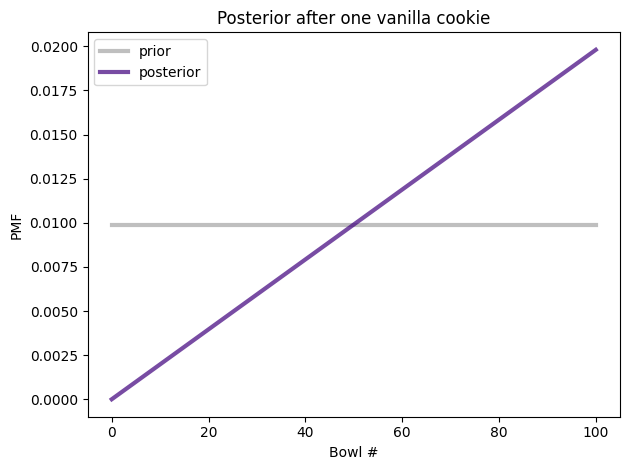

In [28]:
prior.plot(label='prior', color='C5')
posterior1.plot(label='posterior', color='C4')
decorate_bowls('Posterior after one vanilla cookie')

The posterior probability of Bowl 0 is 0 because it contains no vanilla cookies.
The posterior probability of Bowl 100 is the highest because it contains the most vanilla cookies.
In between, the shape of the posterior distribution is a line because the likelihoods are proportional to the bowl numbers.

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie.
Here's the update after the second cookie:

In [29]:
posterior2 = posterior1 * likelihood_vanilla
posterior2.normalize()

np.float64(0.6699999999999999)

And here's what the posterior distribution looks like.

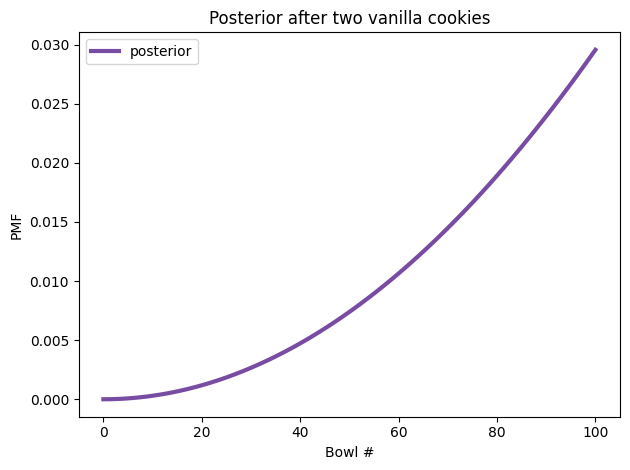

In [30]:
posterior2.plot(label='posterior', color='C4')
decorate_bowls('Posterior after two vanilla cookies')

After two vanilla cookies, the high-numbered bowls have the highest posterior probabilities because they contain the most vanilla cookies; the low-numbered bowls have the lowest probabilities.

But suppose we draw again and get a chocolate cookie.
Here's the update:

In [31]:
likelihood_chocolate = 1 - hypos/100

posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()

np.float64(0.2462686567164179)

And here's the posterior distribution.

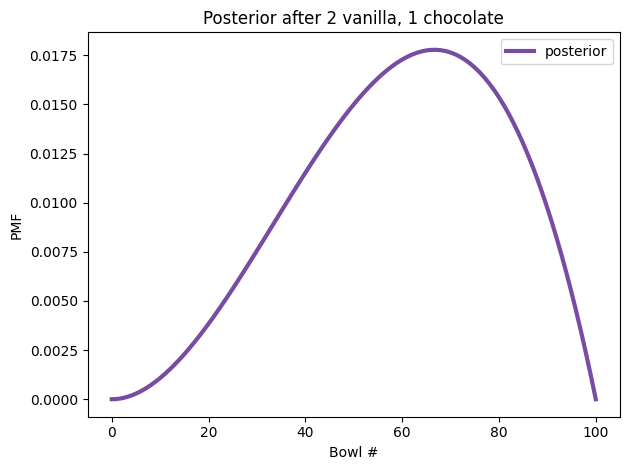

In [32]:
posterior3.plot(label='posterior', color='C4')
decorate_bowls('Posterior after 2 vanilla, 1 chocolate')

Now Bowl 100 has been eliminated because it contains no chocolate cookies.
But the high-numbered bowls are still more likely than the low-numbered bowls, because we have seen more vanilla cookies than chocolate.

In fact, the peak of the posterior distribution is at Bowl 67, which corresponds to the fraction of vanilla cookies in the data we've observed, $2/3$.

The quantity with the highest posterior probability is called the **MAP**, which stands for "maximum a posteriori probability", where "a posteriori" is unnecessary Latin for "posterior".

To compute the MAP, we can use the `Series` method `idxmax`:

In [33]:
posterior3.idxmax()

np.int64(67)

Or `Pmf` provides a more memorable name for the same thing:

In [34]:
posterior3.max_prob()

np.int64(67)

As you might suspect, this example isn't really about bowls; it's about estimating proportions.
Imagine that you have one bowl of cookies.
You don't know what fraction of cookies are vanilla, but you think it is equally likely to be any fraction from 0 to 1.
If you draw three cookies and two are vanilla, what proportion of cookies in the bowl do you think are vanilla?
The posterior distribution we just computed is the answer to that question.

We'll come back to estimating proportions in the next chapter.
But first let's use a `Pmf` to solve the dice problem.

## The Dice Problem

In the previous chapter we solved the dice problem using a Bayes table.
Here's the statement of the problem:

> Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
> I choose one of the dice at random, roll it, and report that the outcome is a 1.
> What is the probability that I chose the 6-sided die?

Let's solve it using a `Pmf`.
I'll use integers to represent the hypotheses:

In [35]:
hypos = [6, 8, 12]

We can make the prior distribution like this:


In [36]:
prior = Pmf(1/3, hypos)
prior

,0
6,0.333333
8,0.333333
12,0.333333


As in the previous example, the prior probability gets broadcast across the hypotheses.
The `Pmf` object has two attributes:

* `qs` contains the quantities in the distribution;

* `ps` contains the corresponding probabilities.

In [37]:
prior.qs

array([ 6,  8, 12])

In [38]:
prior.ps

array([0.33333333, 0.33333333, 0.33333333])

Now we're ready to do the update.
Here's the likelihood of the data for each hypothesis.

In [39]:
likelihood1 = 1/6, 1/8, 1/12

And here's the update.

In [40]:
posterior = prior * likelihood1
posterior.normalize()
posterior

,0
6,0.444444
8,0.333333
12,0.222222


The posterior probability for the 6-sided die is $4/9$.

Now suppose I roll the same die again and get a 7.
Here are the likelihoods:

In [41]:
likelihood2 = 0, 1/8, 1/12

The likelihood for the 6-sided die is 0 because it is not possible to get a 7 on a 6-sided die.
The other two likelihoods are the same as in the previous update.

Here's the update:

In [42]:
posterior *= likelihood2
posterior.normalize()
posterior

,0
6,0.000000
8,0.692308
12,0.307692


After rolling a 1 and a 7, the posterior probability of the 8-sided die is about 69%.

## Updating Dice

The following function is a more general version of the update in the previous section:

In [43]:
def update_dice(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

The first parameter is a `Pmf` that represents the possible dice and their probabilities.
The second parameter is the outcome of rolling a die.

The first line selects quantities from the `Pmf` which represent the hypotheses.
Since the hypotheses are integers, we can use them to compute the likelihoods.
In general, if there are `n` sides on the die, the probability of any possible outcome is `1/n`.

However, we have to check for impossible outcomes!
If the outcome exceeds the hypothetical number of sides on the die, the probability of that outcome is 0.

`impossible` is a Boolean `Series` that is `True` for each impossible outcome.
I use it as an index into `likelihood` to set the corresponding probabilities to 0.

Finally, I multiply `pmf` by the likelihoods and normalize.

Here's how we can use this function to compute the updates in the previous section.
I start with a fresh copy of the prior distribution:


In [44]:
pmf = prior.copy()
pmf

,0
6,0.333333
8,0.333333
12,0.333333


And use `update_dice` to do the updates.

In [45]:
update_dice(pmf, 1)
update_dice(pmf, 7)
pmf

,0
6,0.000000
8,0.692308
12,0.307692


The result is the same.  We will see a version of this function in the next chapter.

## Summary

This chapter introduces the `empiricaldist` module, which provides `Pmf`, which we use to represent a set of hypotheses and their probabilities.

`empiricaldist` is based on Pandas; the `Pmf` class inherits from the Pandas `Series` class and provides additional features specific to probability mass functions.
We'll use `Pmf` and other classes from `empiricaldist` throughout the book because they simplify the code and make it more readable.
But we could do the same things directly with Pandas.

We use a `Pmf` to solve the cookie problem and the dice problem, which we saw in the previous chapter.
With a `Pmf` it is easy to perform sequential updates with multiple pieces of data.

We also solved a more general version of the cookie problem, with 101 bowls rather than two.
Then we computed the MAP, which is the quantity with the highest posterior probability.

In the next chapter, I'll introduce the Euro problem, and we will use the binomial distribution.
And, at last, we will make the leap from using Bayes's Theorem to doing Bayesian statistics.

But first you might want to work on the exercises.

## Exercises

**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it four times, and get 1, 3, 5, and 7.
What is the probability that I chose the 8-sided die?

You can use the `update_dice` function or do the update yourself.

In [57]:
# Solution goes here
values=[1,3,5,7]
pmf=prior.copy()
for item in values:
   update_dice(pmf,item)
pmf

,0
6,0.000000
8,0.835052
12,0.164948


**Exercise:** In the previous version of the dice problem, the prior probabilities are the same because the box contains one of each die.
But suppose the box contains 1 die that is 4-sided, 2 dice that are 6-sided, 3 dice that are 8-sided, 4 dice that are 12-sided, and 5 dice that are 20-sided.
I choose a die, roll it, and get a 7.
What is the probability that I chose an 8-sided die?

Hint: To make the prior distribution, call `Pmf` with two parameters.

In [60]:
# A solução vai aqui
qs = [ 4 , 6 , 8 , 12 , 20 ]
ps = [ 1 , 2 , 3 , 4 , 5 ]
pmf = Pmf(ps, qs)
pmf.normalize()
update_dice(pmf, 7 )
pmf

,0
4,0.000000
6,0.000000
8,0.391304
12,0.347826
20,0.260870


**Exercise:** Suppose I have two sock drawers.
One contains equal numbers of black and white socks.
The other contains equal numbers of red, green, and blue socks.
Suppose I choose a drawer at random, choose two socks at random, and I tell you that I got a matching pair.
What is the probability that the socks are white?

For simplicity, let's assume that there are so many socks in both drawers that removing one sock makes a negligible change to the proportions.

In [67]:
# Solution goes here
hypos = ['BlackWhite', 'RedGreenBlue']
prior = Pmf(1/2, hypos)
likelihood = 1/2, 1/3
posterior = prior * likelihood
posterior.normalize()
posterior

,0
BlackWhite,0.6
RedGreenBlue,0.4


**Exercise:** Here's a problem from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/):

> Elvis Presley had a twin brother (who died at birth). What is the probability that Elvis was an identical twin?

Hint: In 1935, about 2/3 of twins were fraternal and 1/3 were identical.

In [63]:
# Solution goes here
hypos=["fraternal", "identical"]
prior = [2/3, 1/3]
prob_twins_identical=Pmf(prior,hypos)
display(prob_twins_identical)

,0
fraternal,0.666667
identical,0.333333


In [51]:
# Solution goes here

In [52]:
# Solution goes here